In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pymongo as pm
from pymongo import MongoClient
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
orderedCols = ['matchId', 'teamId', 'isHome',
               'meanPlayerOverall', 'meanPlayerPotential', 'meanPrevScore', 'meanPrevScoreET', 'meanPrevScoreHT', 'meanPrevScoreP',
               'numPass', 'numAccuratePass', 'rateAccuratePass', 
               'numDuel', 'numFoul', 'numFreeKick', 'numGoalkeeperLeavingLine', 'numInterruption', 'numOffside', 'numOthersOnTheBall', 'numSaveAttempt', 'numShot',
               'numYellowCard', 'numSecondYellowCard', 'numRedCard',
               'percBallPoss', 'percOppHalfField',
               'numGoalsFristHalf', 'numSecondHalfGoals', 'finalScore',
               'isWinner', 'didScoreInSecondHalf' ]

# DataFrame

In [13]:
res = pd.read_csv('./results.csv')
res.head()

,matchId,teamId,isHome,meanPlayerOverall,meanPlayerPotential,meanPrevScore,meanPrevScoreET,meanPrevScoreHT,meanPrevScoreP,numPass,...,numYellowCard,numSecondYellowCard,numRedCard,percBallPoss,percOppHalfField,numGoalsFristHalf,numSecondHalfGoals,finalScore,isWinner,didScoreInSecondHalf
0,2057983,6697,True,50.434783,52.304348,1.50,0.0,0.000000,0.0,307,...,1,0,0,55.590452,19.660804,1,1,2,0,1
1,2058011,6380,True,53.217391,54.434783,1.75,0.0,0.500000,0.0,244,...,0,0,0,54.193139,31.766201,0,1,1,0,1
2,2058003,12274,False,53.173913,53.782609,1.00,0.0,0.666667,0.0,281,...,3,0,0,53.295933,29.733520,1,2,3,0,1
3,2057981,6697,False,50.434783,52.304348,1.00,0.0,0.000000,0.0,290,...,0,0,0,56.089944,24.859463,0,2,2,1,1
4,2057967,15594,True,40.043478,41.434783,0.00,0.0,0.000000,0.0,158,...,1,0,0,49.213944,25.017088,0,0,0,0,0


In [226]:
df = res.drop(['teamId', 'matchId', 'isHome'], axis=1)
df_noTarget = res.drop(['teamId', 'matchId', 'isHome', 'isWinner', 'didScoreInSecondHalf'], axis=1)
target1 = 'isWinner'
target2 = 'didScoreInSecondHalf'

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meanPlayerOverall,3882.0,48.274117,11.032427,0.000000,41.861111,48.468750,56.400000,79.000000
meanPlayerPotential,3882.0,50.987488,11.704339,0.000000,44.416667,51.406250,58.806452,81.304348
meanPrevScore,3882.0,1.280416,0.707377,0.000000,0.857143,1.161726,1.666667,5.000000
meanPrevScoreET,3882.0,0.001069,0.021683,0.000000,0.000000,0.000000,0.000000,0.833333
meanPrevScoreHT,3882.0,0.557412,0.362989,0.000000,0.333333,0.500000,0.750000,3.000000
meanPrevScoreP,3882.0,0.002851,0.054750,0.000000,0.000000,0.000000,0.000000,1.400000
numPass,3882.0,220.728490,69.505308,61.000000,171.000000,213.000000,263.000000,584.000000
numAccuratePass,3882.0,183.804225,67.918820,39.000000,134.000000,174.500000,225.000000,546.000000
rateAccuratePass,3882.0,0.818617,0.058756,0.571429,0.783626,0.826418,0.861977,0.938172
numDuel,3882.0,109.849047,18.464208,60.000000,97.000000,110.000000,122.000000,200.000000


# Data Visualization

### Correlation

In [ ]:
corr = df.corr()

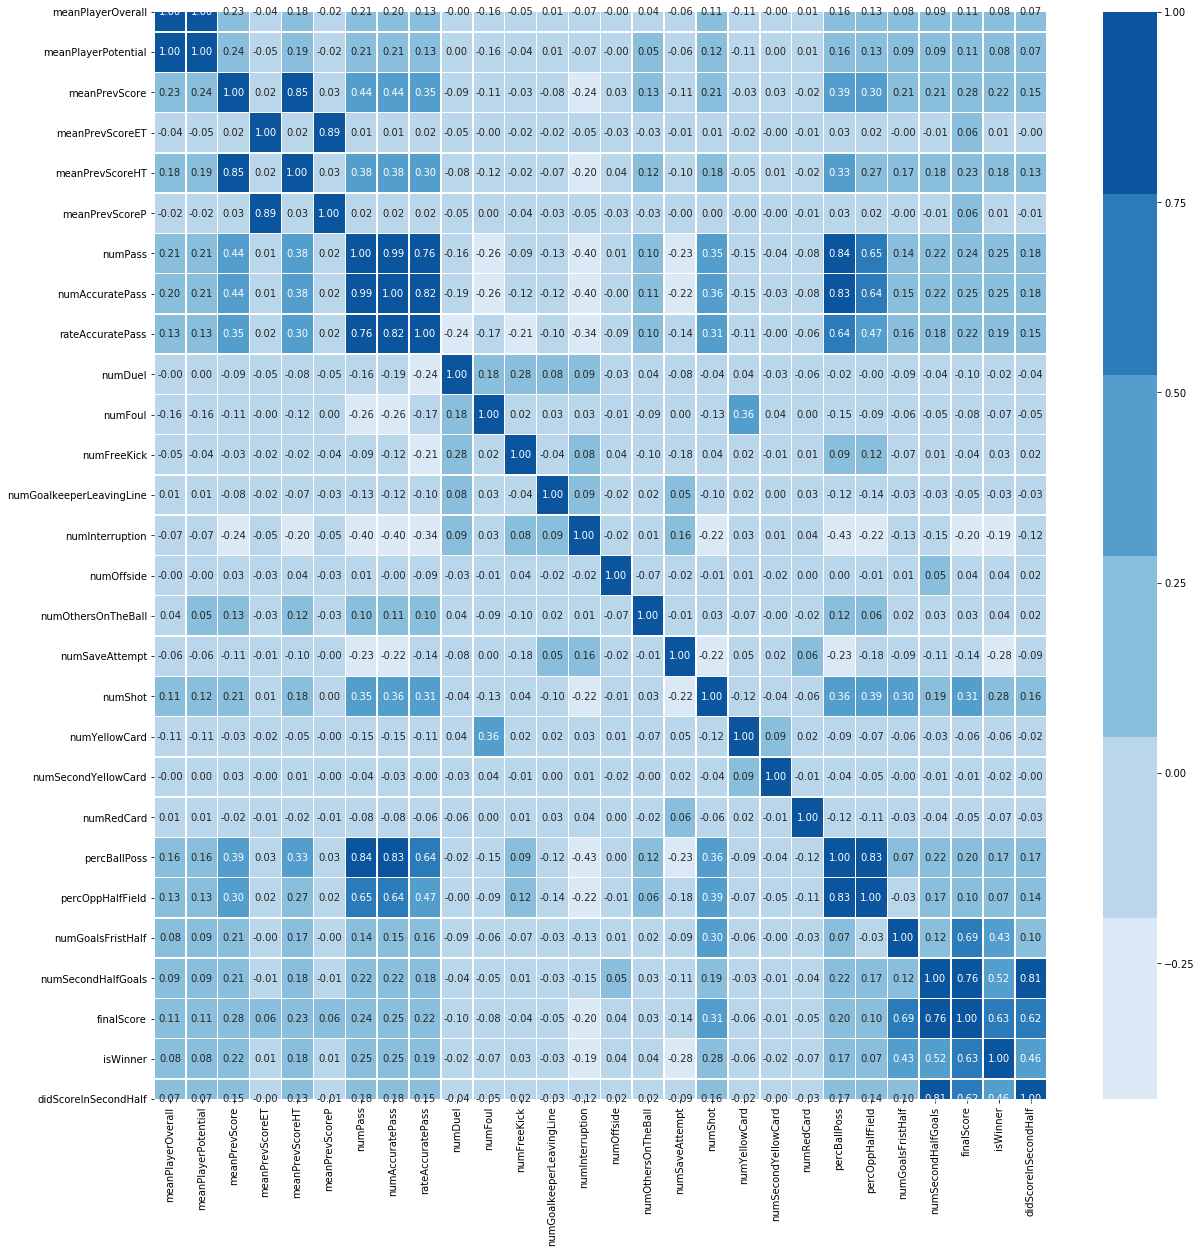

In [222]:
plt.figure(figsize =(20, 20))
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, fmt=".2f", linewidths=.5, cmap=sns.color_palette("Blues"))
#plt.savefig('corrMat.pdf')

### Scatter matrix

In [237]:
def scatter_matrix (df, atts, target):
    sns.set(style="ticks")
    sns.pairplot(df[atts], hue=target, a)

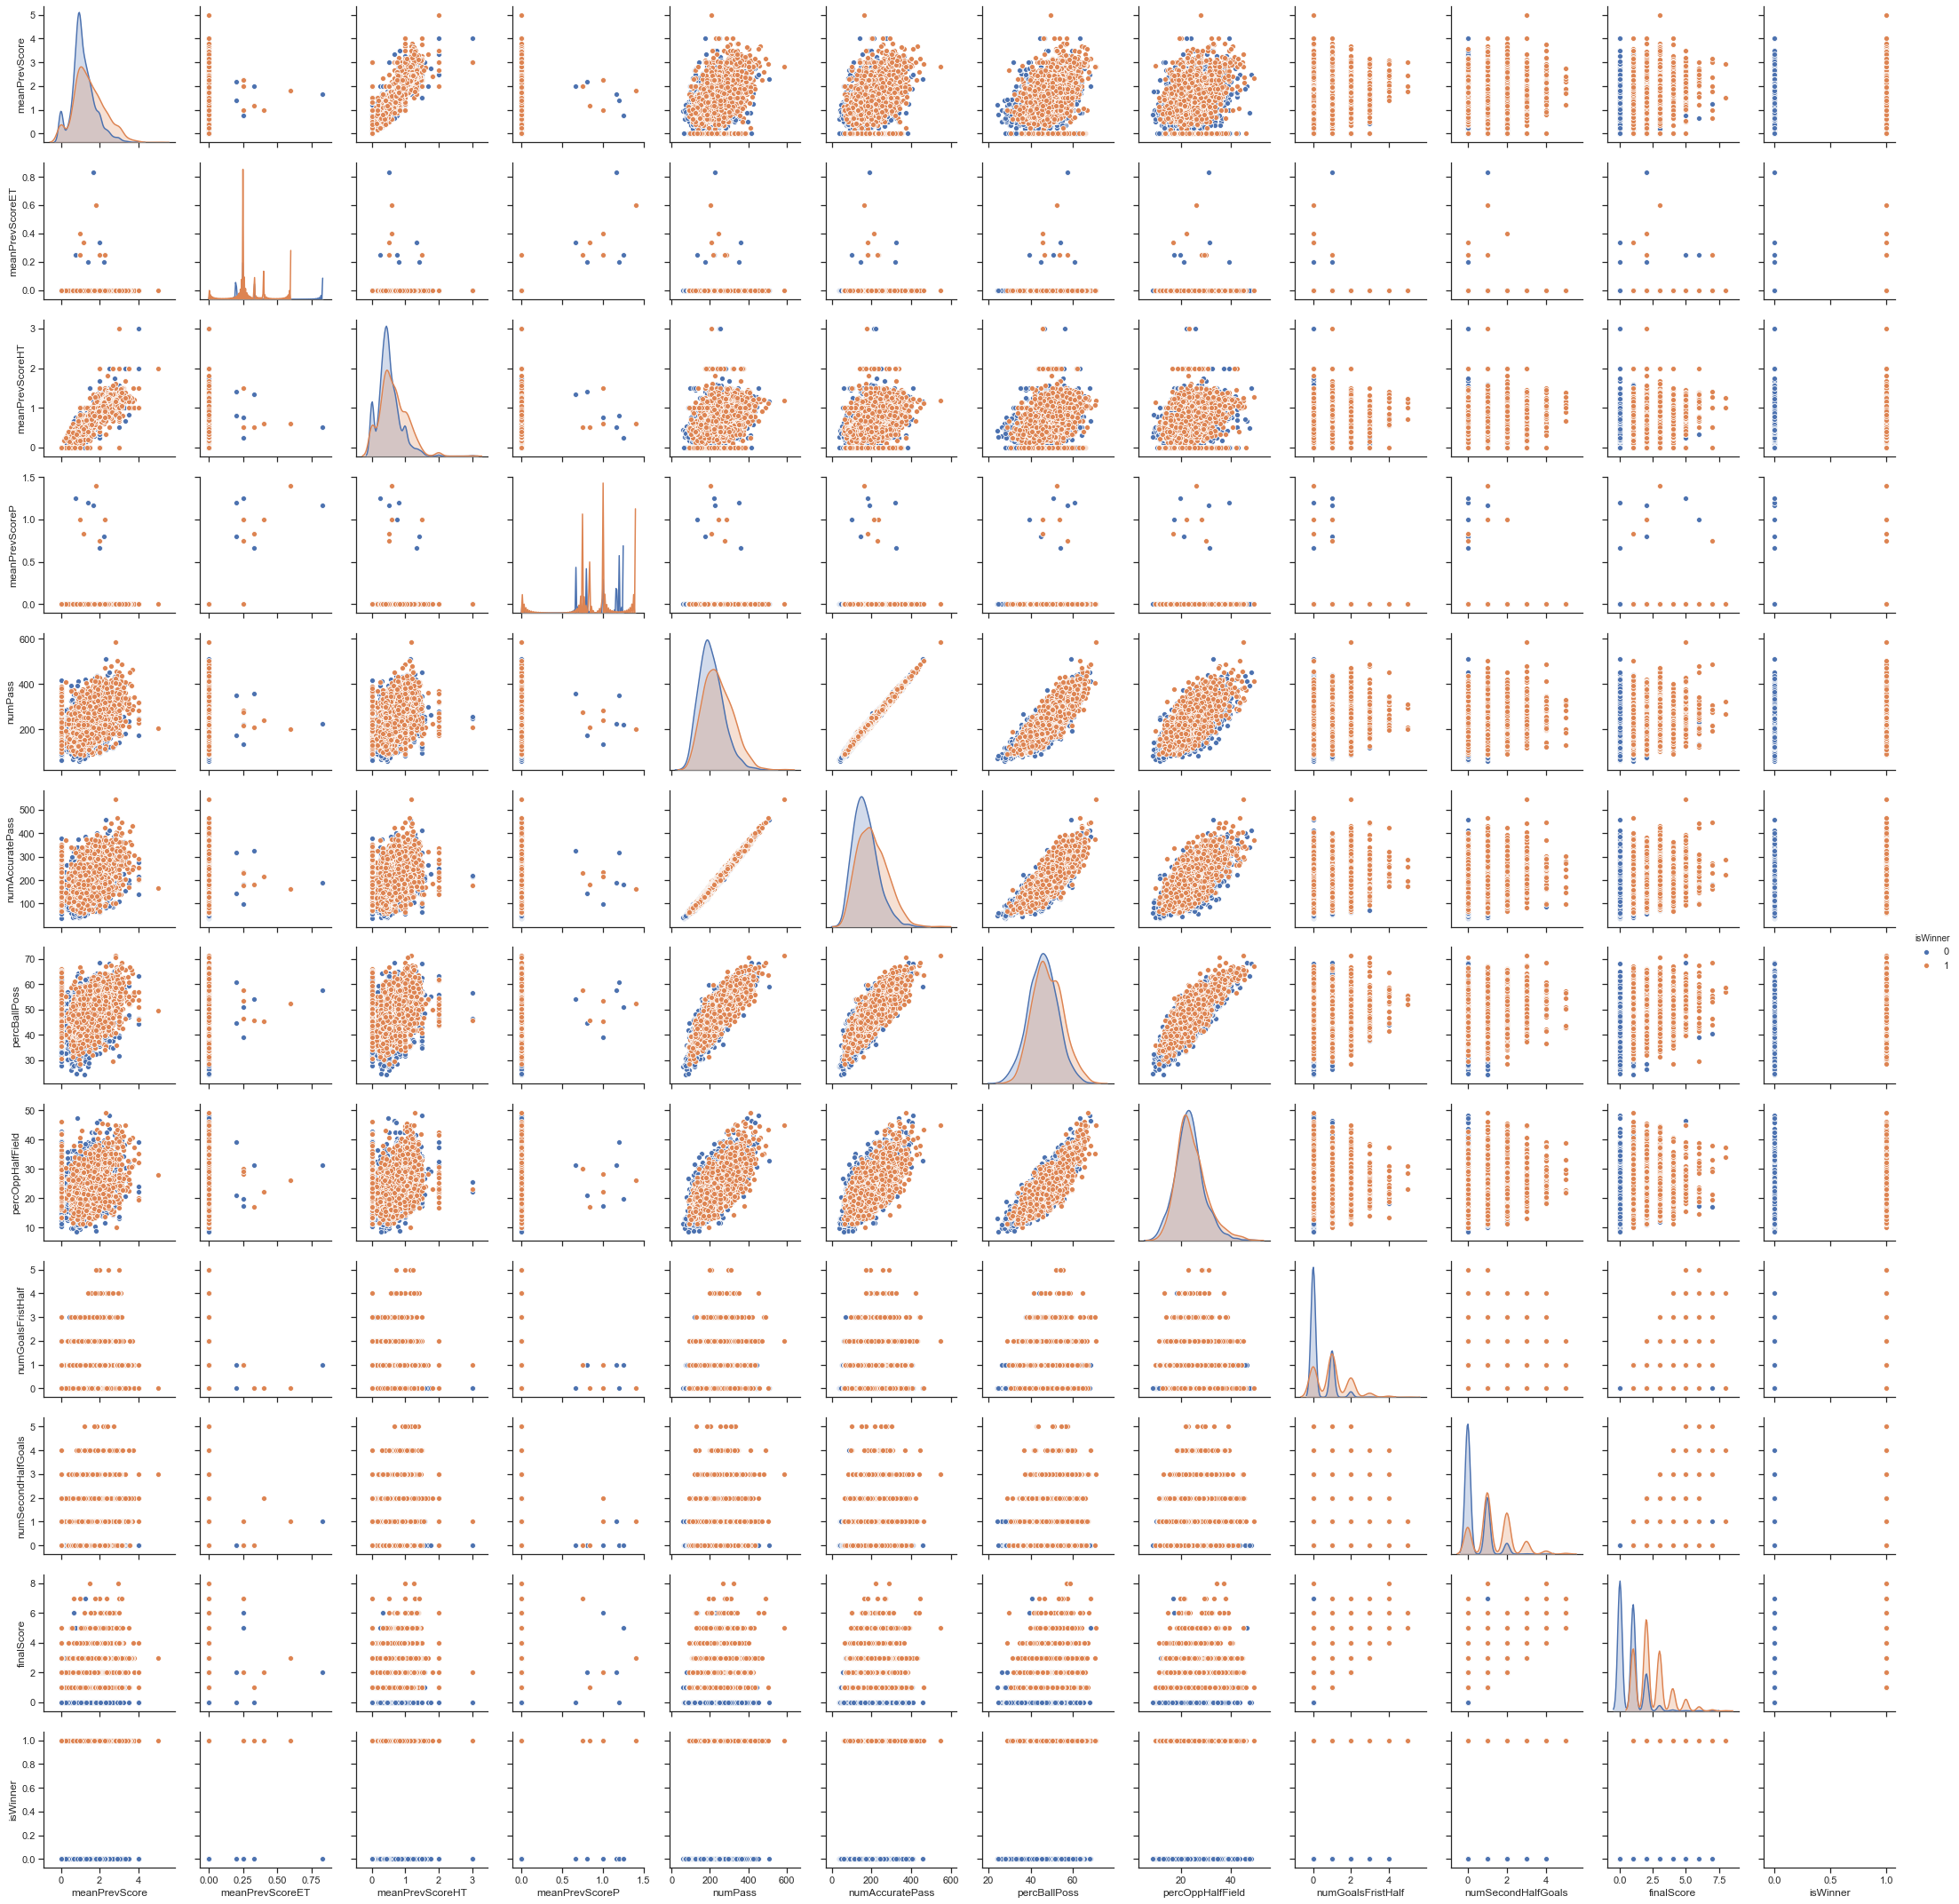

In [238]:
scatter_matrix(df.drop([target2],axis=1), ['meanPrevScore', 'meanPrevScoreET', 'meanPrevScoreHT', 'meanPrevScoreP',
                        'numPass', 'numAccuratePass',
                        'percBallPoss', 'percOppHalfField',
                        'numGoalsFristHalf', 'numSecondHalfGoals', 'finalScore',
                        target1], target1)

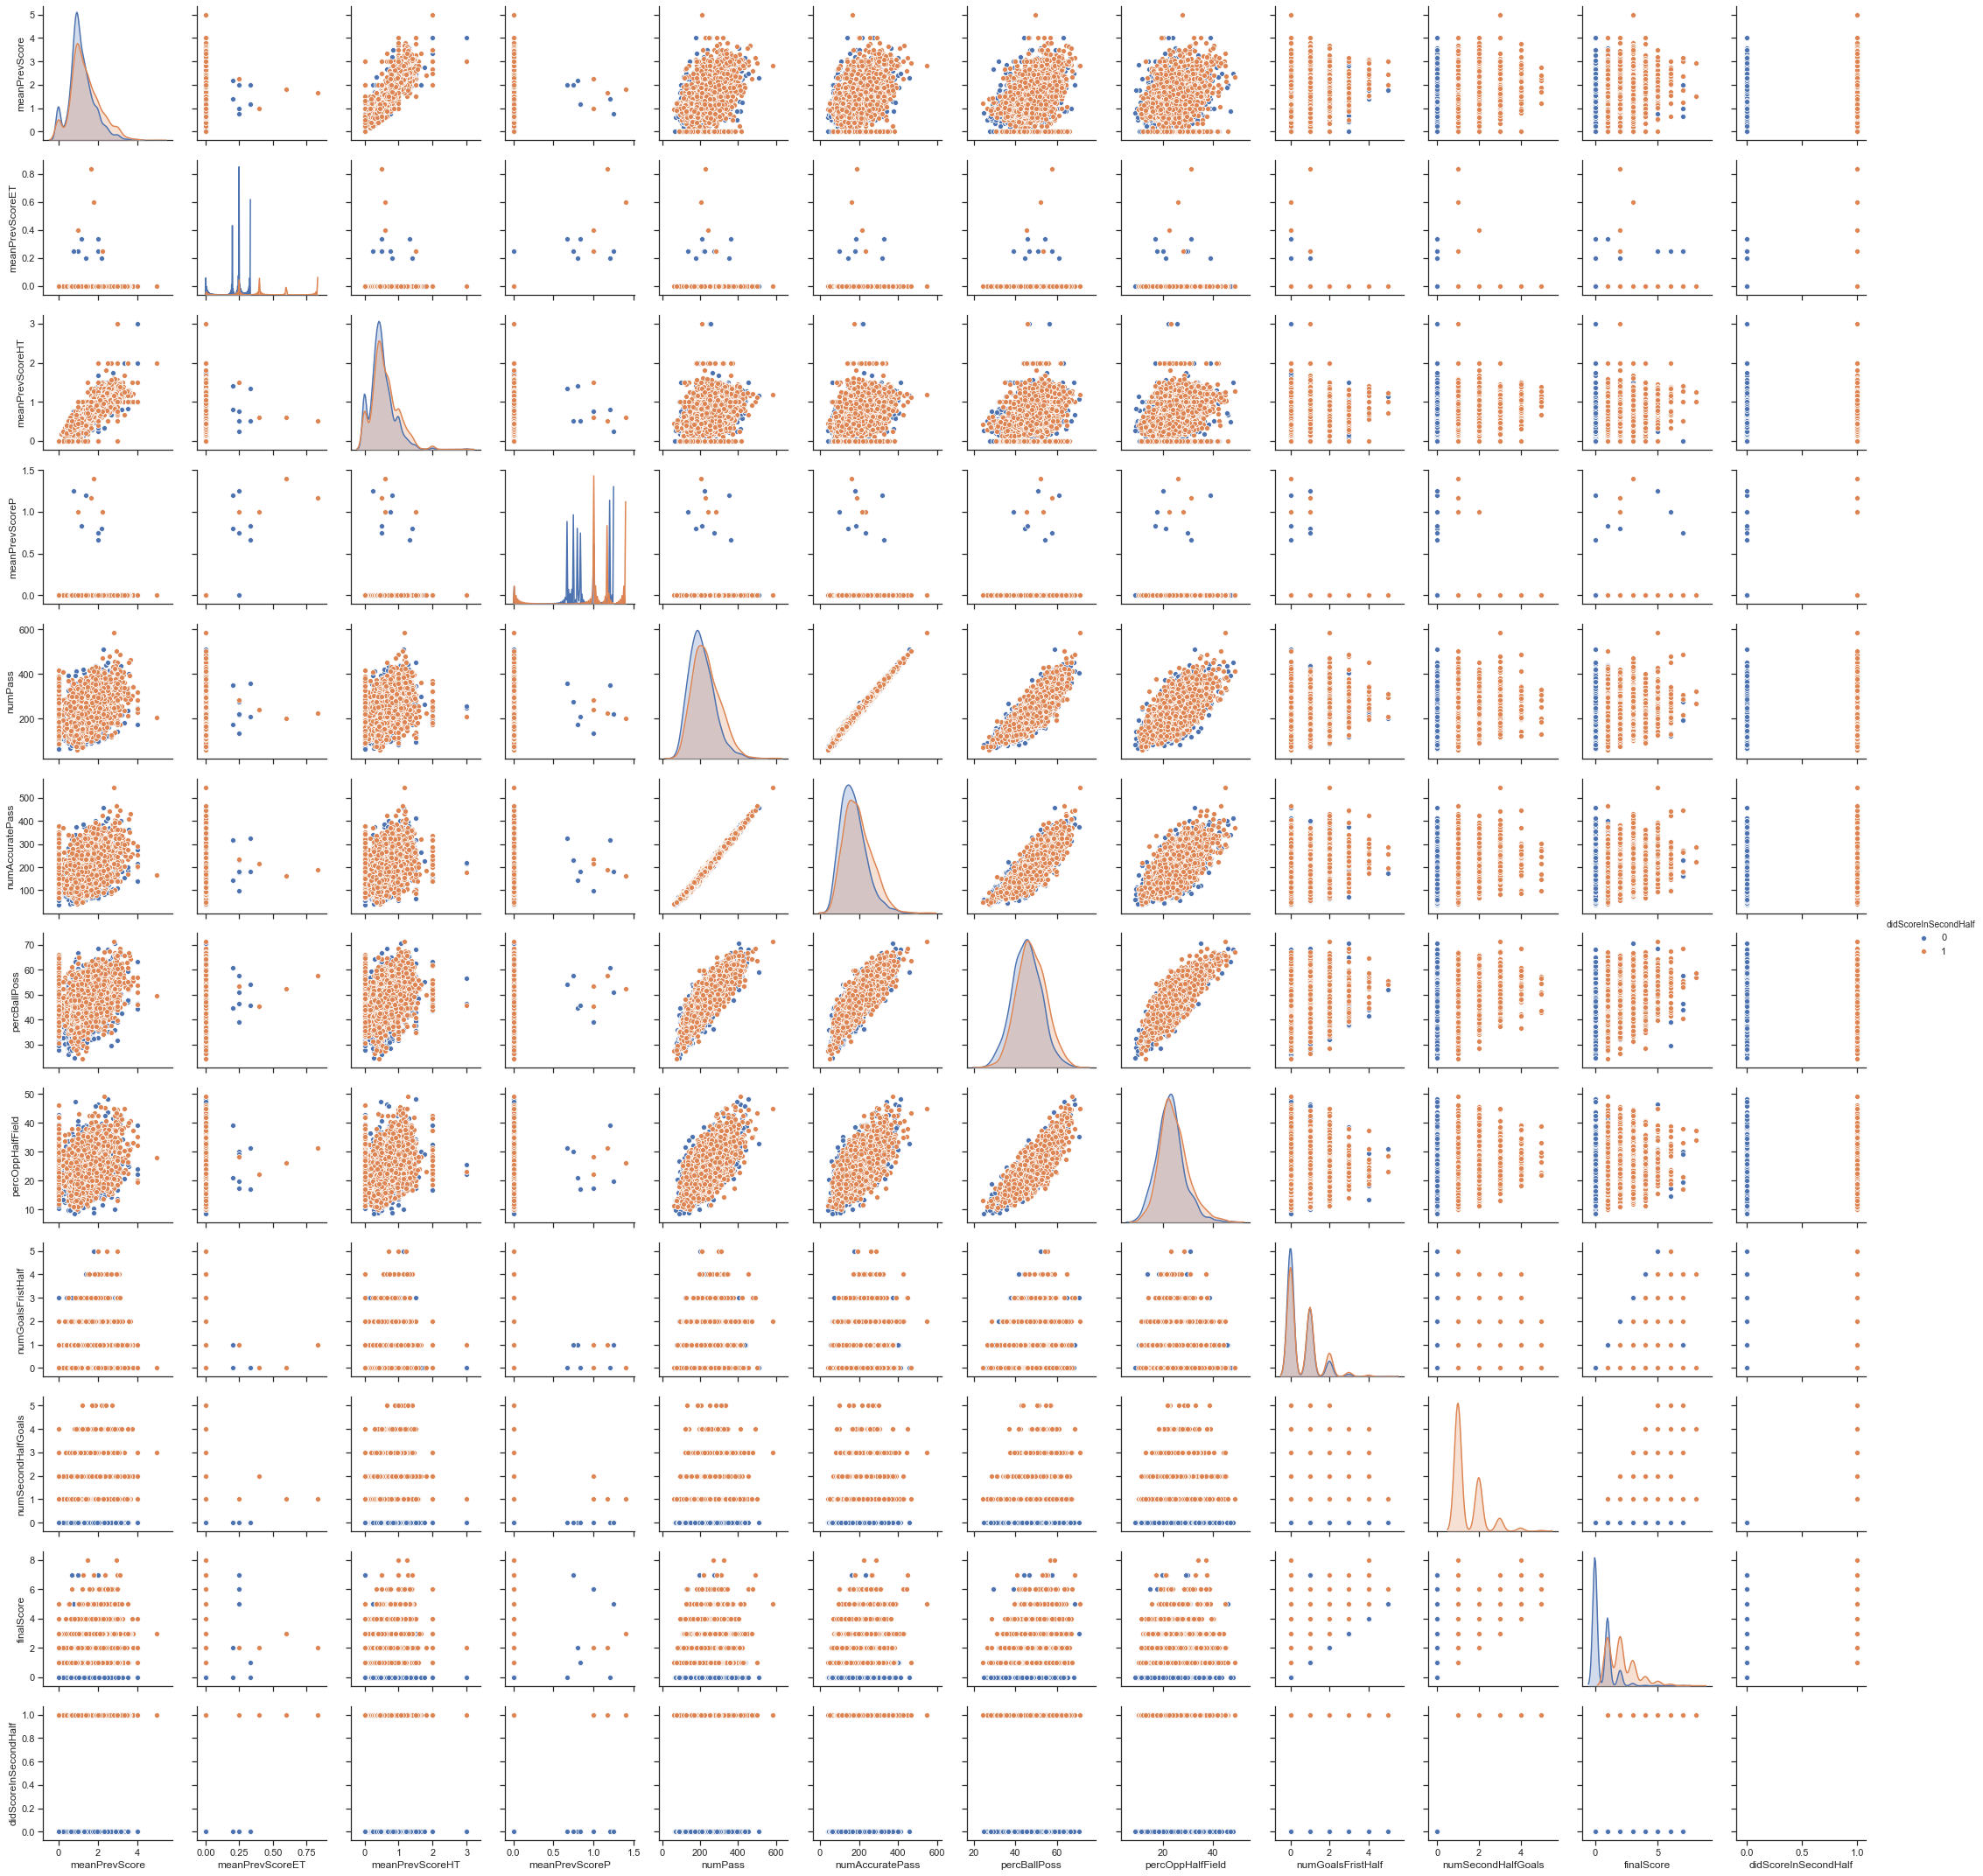

In [240]:
scatter_matrix(df.drop([target1],axis=1), ['meanPrevScore', 'meanPrevScoreET', 'meanPrevScoreHT', 'meanPrevScoreP',
                        'numPass', 'numAccuratePass',
                        'percBallPoss', 'percOppHalfField',
                        'numGoalsFristHalf', 'numSecondHalfGoals', 'finalScore',
                        target2], target2)

### Scatter plots

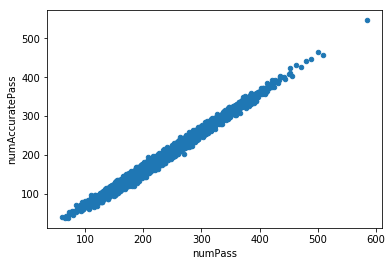

In [25]:
df.plot.scatter(y='numAccuratePass', x='numPass')

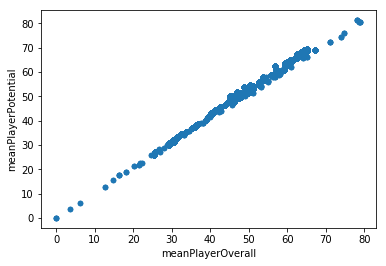

In [26]:
df.plot.scatter(y='meanPlayerPotential', x='meanPlayerOverall')

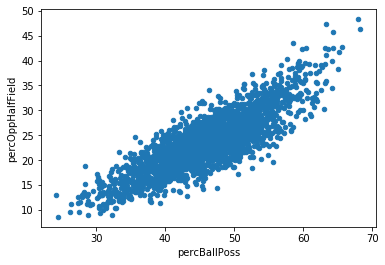

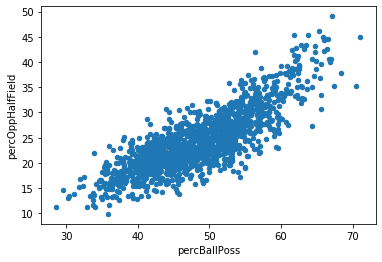

In [224]:
plt.subplot(1,2)
df[df[target1]==0].plot.scatter(x='percBallPoss', y='percOppHalfField')
df[df[target1]==1].plot.scatter(x='percBallPoss', y='percOppHalfField')

## Histogram

#### Mean of the number each event

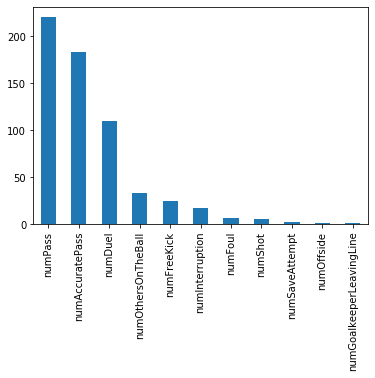

In [203]:
df_noTarget.mean()[['numPass', 'numAccuratePass',
               'numDuel', 'numFoul', 'numFreeKick', 'numGoalkeeperLeavingLine', 'numInterruption', 'numOffside', 'numOthersOnTheBall', 'numSaveAttempt', 'numShot']].sort_values(ascending=False).plot.bar()

In [20]:
def plot_histogram_per_attribute(df, att, size):
    fig = plt.figure(figsize=(size, size)) 
    fig_dims = (2, 2)
    
    plt.subplot2grid(fig_dims, (0, 0)) #(0,1), (1,0) (1,1)
    plt.hist(df[att], alpha=0.5, #bins=20, normed=True, 
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
    plt.title(att.title() + ' Histogram')
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")


## Density plot

For each attribute we show the density plot twice, one for each target field

In [197]:
# Plotting the KDE Plot 
def kde_att_target (df, att, target):
    sns.kdeplot(df.loc[(df[target]==0), att], color='r', shade=True, Label=target + ' = 0') 
    sns.kdeplot(df.loc[(df[target]==1), att], color='b', shade=True, Label=target + ' = 1') 

    plt.xlabel(att) 
    plt.ylabel('Probability Density') 
    plt.show()


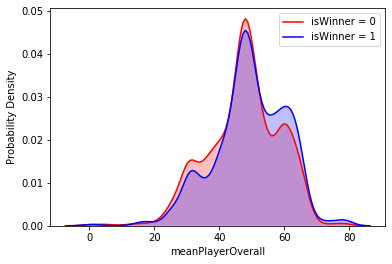

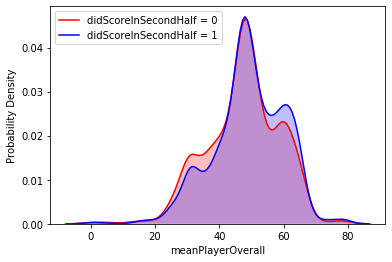

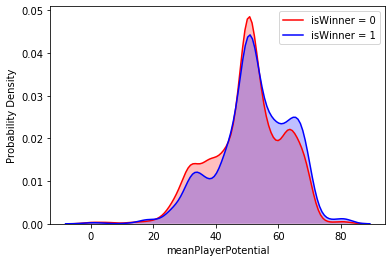

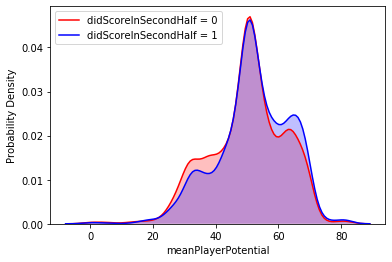

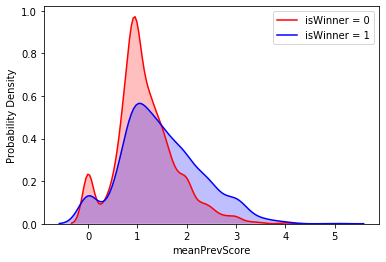

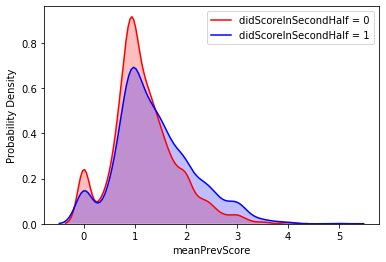

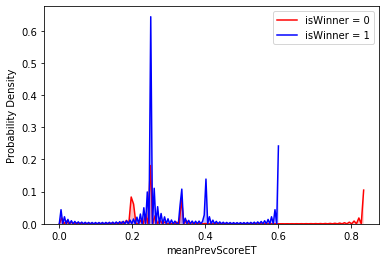

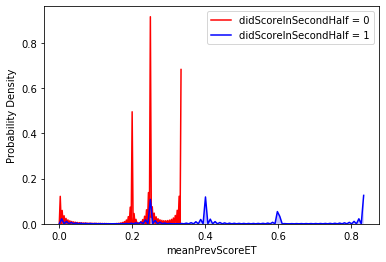

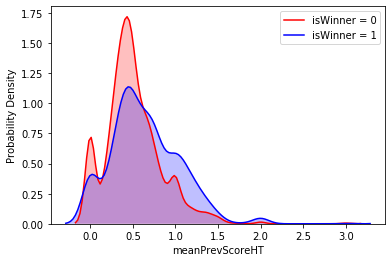

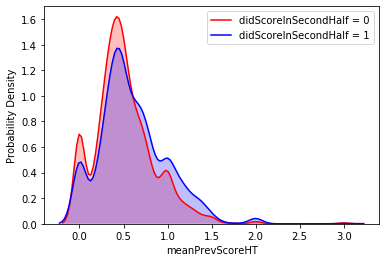

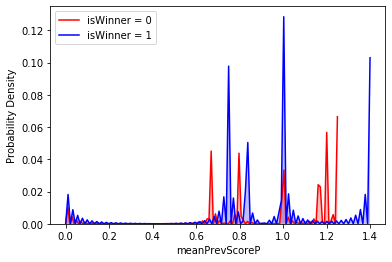

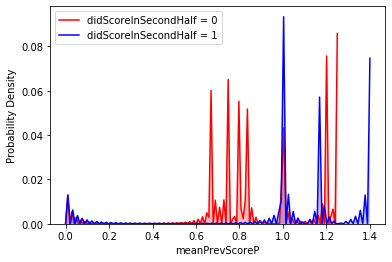

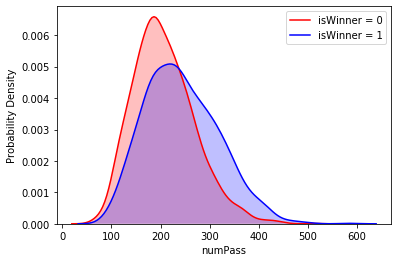

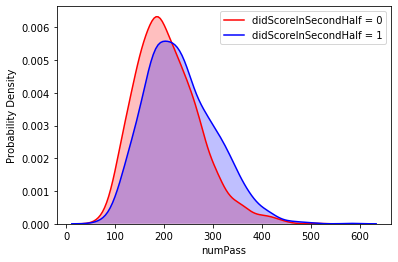

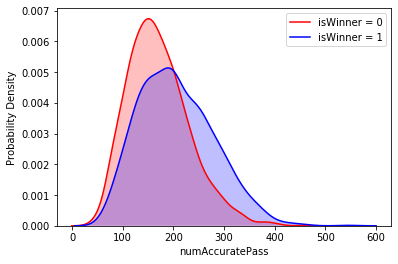

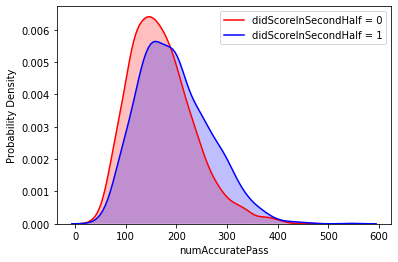

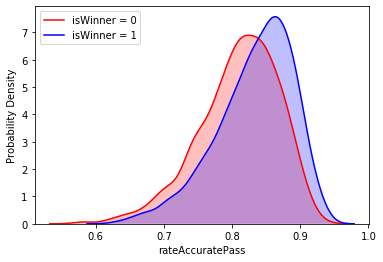

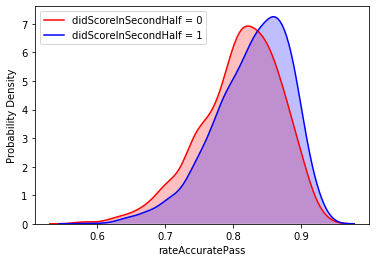

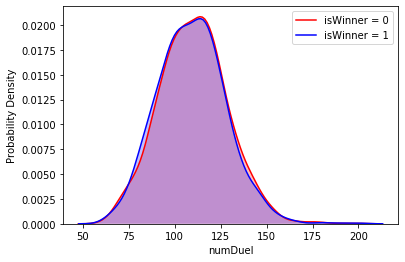

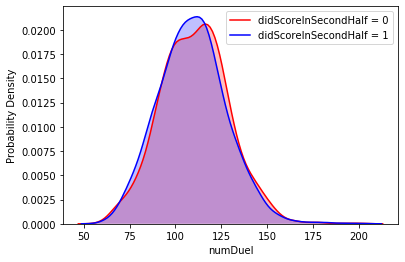

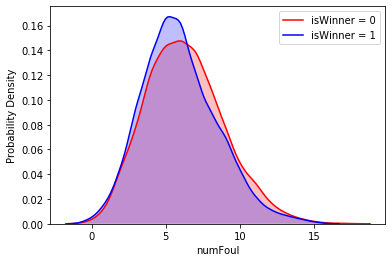

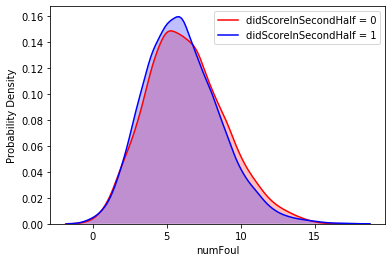

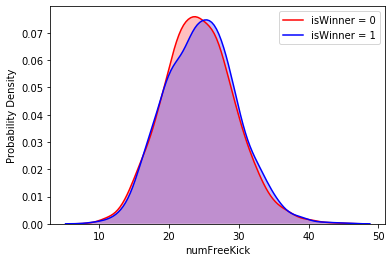

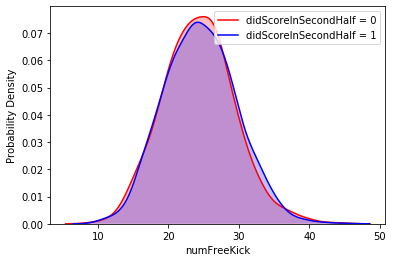

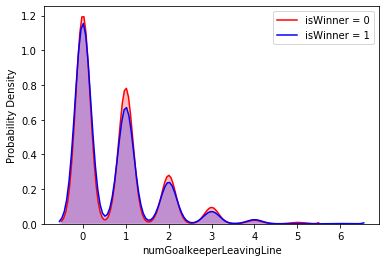

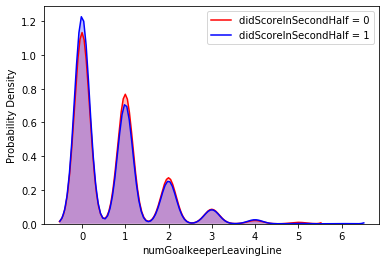

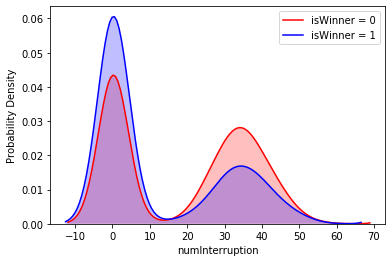

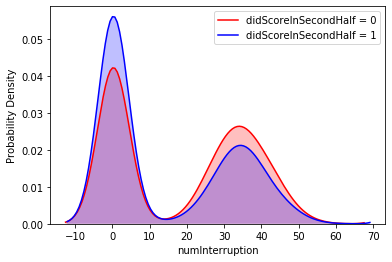

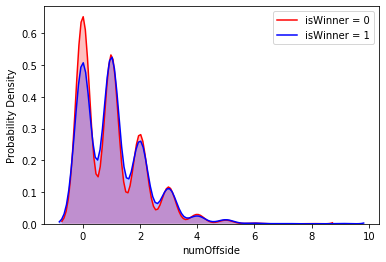

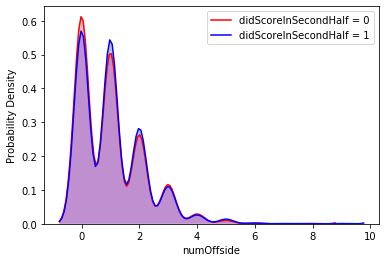

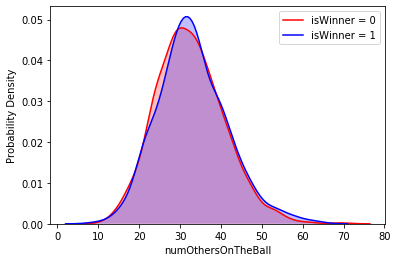

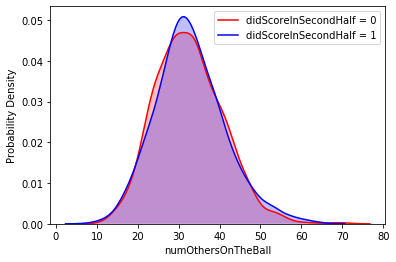

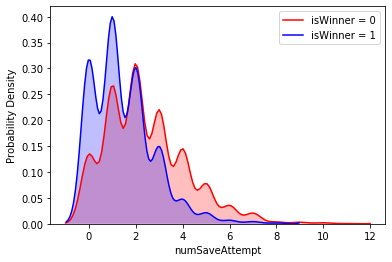

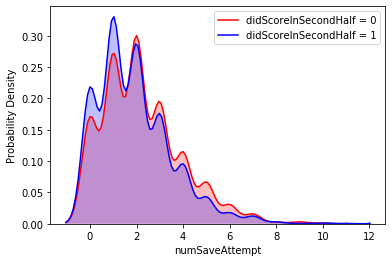

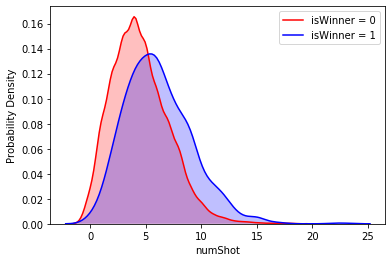

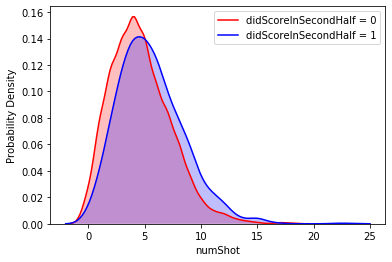

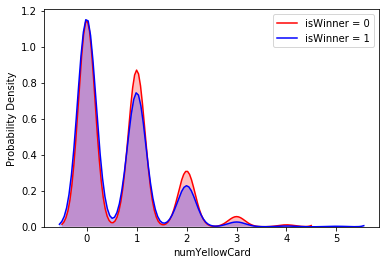

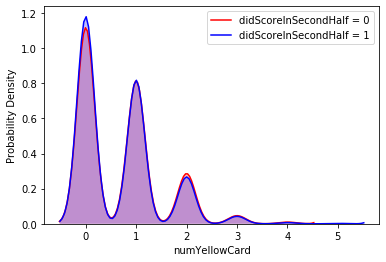

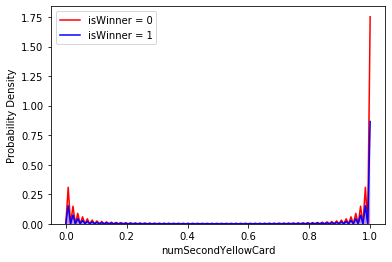

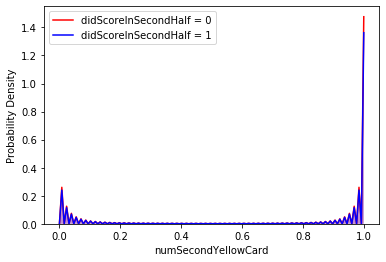

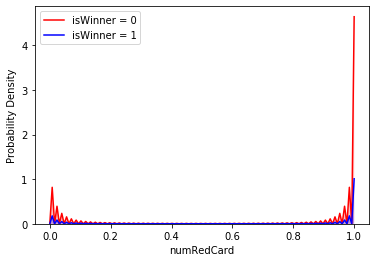

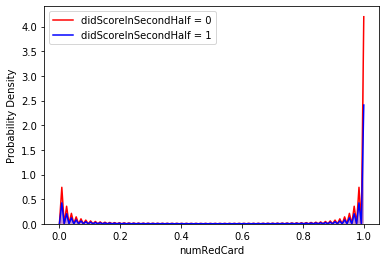

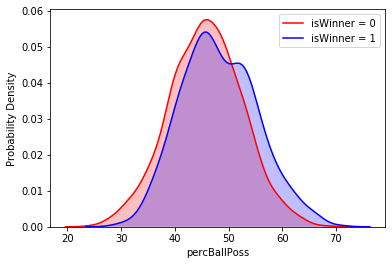

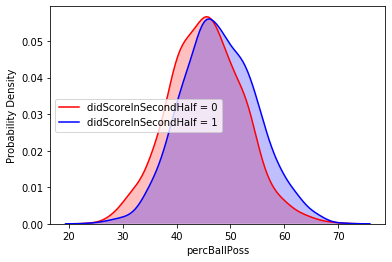

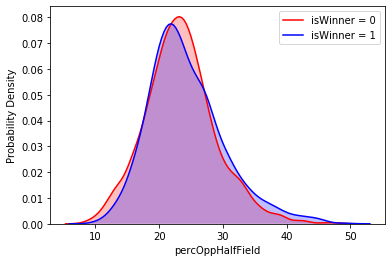

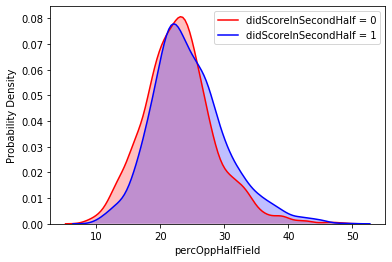

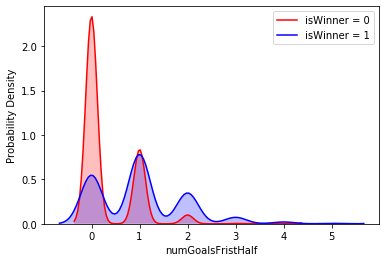

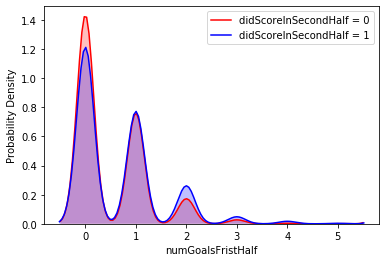

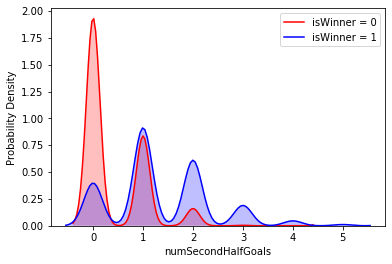

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/martincastellani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


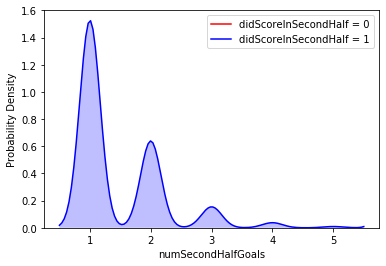

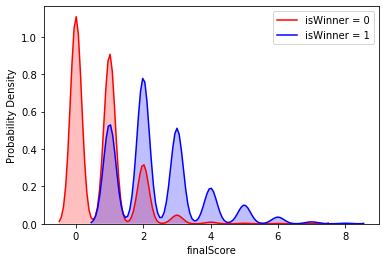

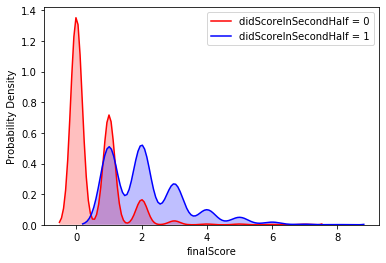

In [199]:
#for e in ['numPass', 'numAccuratePass', 'numDuel', 'numFoul', 'numFreeKick', 'numGoalkeeperLeavingLine', 'numInterruption', 'numOffside', 'numOthersOnTheBall', 'numSaveAttempt', 'numShot']:
for e in df_noTarget.columns:
    kde_att_target(df, e, target1)
    kde_att_target(df, e, target2)

### Crosstab

### Plot cutting the datframe in bins

In [59]:
#this function plot the crosstab for an attribute and one target
def plot_crosstab_target(df, attribute, target, nB, size):
    crosstab = pd.crosstab(pd.cut(df[attribute], nB), df[target])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True,
                   title='There is a goal in 2HT by ' + str(attribute) )
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/ps-default" + str(attribute) + ".pdf")

In [26]:
#this function plot the histodram of the distribution and crosstab for an attribute and one target
def plot_crosstab_and_hist(df, att, target, nB, size):
    #fig = plt.figure(figsize=(size, size)) 
    plt.hist(df[att], bins=nB, alpha=0.5, #bins=20, normed=True, 
         rwidth=0.5)
    plt.title(att.title() + ' Histogram')
    
    crosstab = pd.crosstab(pd.cut(df[att], nB), df[target])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True)
                   #,title='There is a goal in 2HT by ' + str(att) )
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")

In [243]:
#this function plot the histodram of the distribution and crosstab for an attribute and both targets
def plot_crosstab_and_hist_2target(df, att, nB, size):
    #fig = plt.figure(figsize=(size, size)) 
    plt.hist(df[att], bins=nB, alpha=0.5, #bins=20, normed=True, 
         rwidth=0.5)
    plt.title(att.title() + ' Histogram')
    
    crosstab = pd.crosstab(pd.cut(df[att], nB), df[target1])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True)
                   #,title='There is a goal in 2HT by ' + str(att) )
    
    crosstab = pd.crosstab(pd.cut(df[att], nB), df[target2])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True)
                   #,title='There is a goal in 2HT by ' + str(att) )
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")

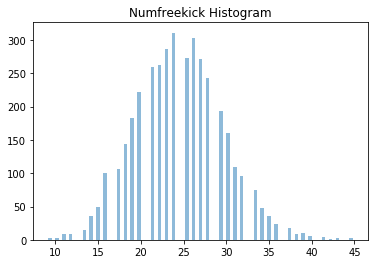

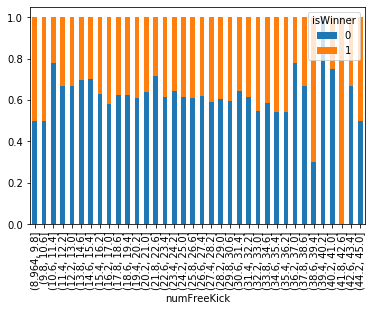

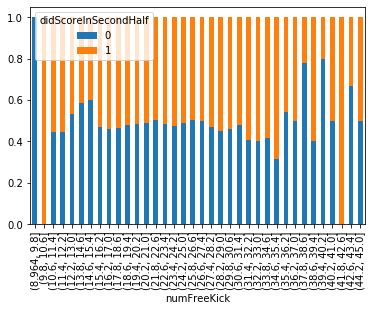

In [205]:
plot_crosstab_and_hist_2target(res, 'numFreeKick', 45, 10)

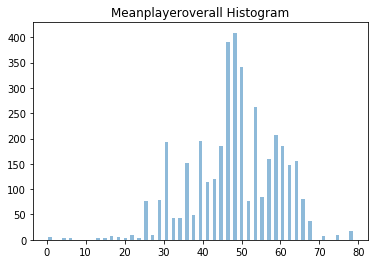

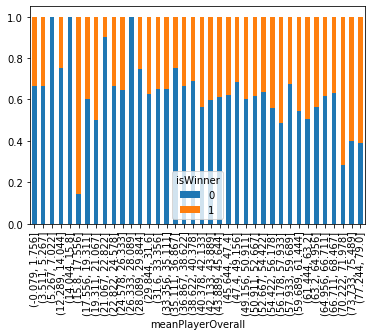

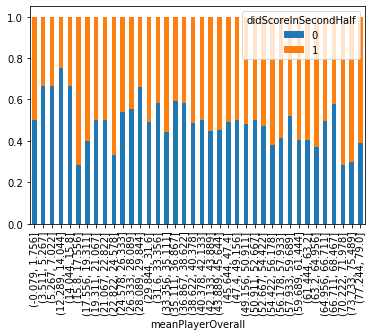

In [206]:
plot_crosstab_and_hist_2target(res, 'meanPlayerOverall', 45, 10)

### Plot without cutting the dataframe in bins

In [141]:
def plot_crosstab_and_hist_2target_noCut(df, att, size):
    #fig = plt.figure(figsize=(size, size)) 
    cnt = Counter(list(df[att]))
    keys = sorted(cnt.keys())
    
    plt.bar(keys, [cnt[k] for k in keys], width=0.5)
    plt.title(att.title() + ' Histogram')
    
    crosstab = pd.crosstab(df[att], df[target1])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True)
                   #,title='There is a goal in 2HT by ' + str(att) )
    
    crosstab = pd.crosstab(df[att], df[target2])
    # Normalize the cross tab to sum to 1:
    crosstab_normalized = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    
    crosstab_normalized.plot(kind='bar', stacked=True)
                   #,title='There is a goal in 2HT by ' + str(att) )
    
    plt.show()
    #plt.savefig("/home/daniele/dm-local/age_ba_pa_limit_hist.pdf")

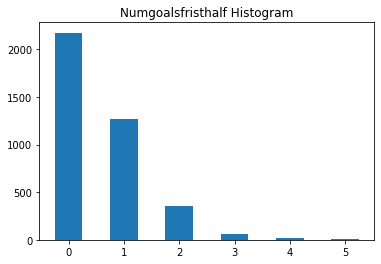

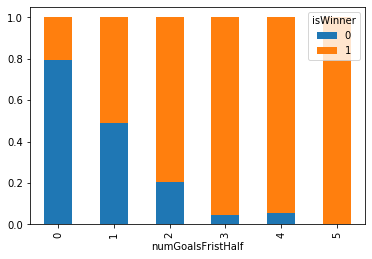

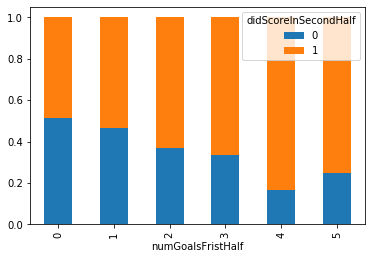

In [142]:
plot_crosstab_and_hist_2target_noCut(res, 'numGoalsFristHalf', 10)

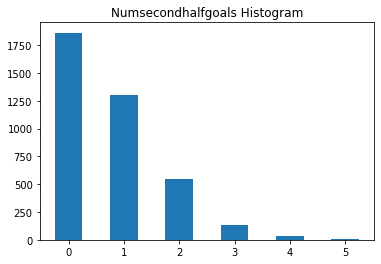

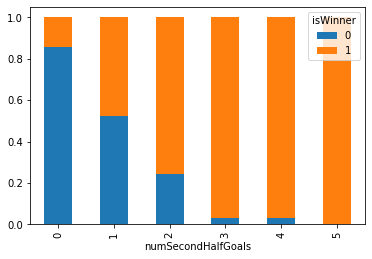

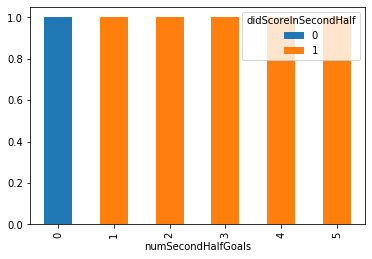

In [143]:
plot_crosstab_and_hist_2target_noCut(res, 'numSecondHalfGoals', 10)

### Features importance

In [23]:
def plot_features_importance (X, y, n = None ):
    if n == None:
        n = len(X.columns)
    model = ExtraTreesClassifier()
    model.fit(X,y)
    print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.show()

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.02038737 0.03482537 0.03575484 0.05422775 0.00129066 0.04376914
 0.00138003 0.0489158  0.0441401  0.03661333 0.03972271 0.02908677
 0.1438707  0.04488462 0.03290352 0.04069985 0.04884272 0.0032647
 0.06711877 0.00144868 0.05835057 0.03231642 0.04777569 0.0419724
 0.04643748]


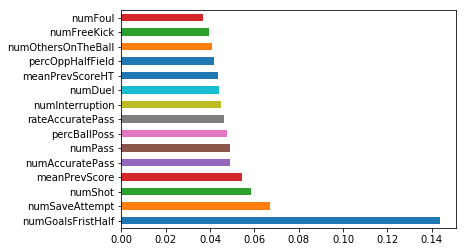

/Users/martincastellani/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.02226639 0.04779416 0.05040889 0.05194885 0.00115608 0.04988466
 0.00083402 0.05005753 0.04974513 0.04828382 0.05139794 0.03885634
 0.0334107  0.05109178 0.04331251 0.05100882 0.05239051 0.00432633
 0.04828575 0.00254809 0.05396309 0.03896775 0.05350928 0.05171474
 0.05283684]


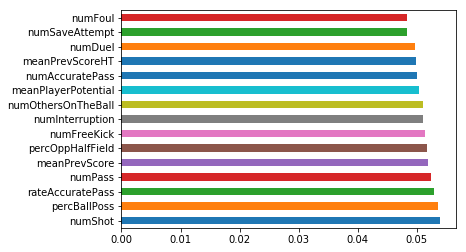

In [75]:
plot_features_importance( df_noTarget.drop(['numSecondHalfGoals', 'finalScore'], axis=1), df[target1], 15)
plot_features_importance( df_noTarget.drop(['numSecondHalfGoals', 'finalScore'], axis=1), df[target2], 15)